# Imports

In [12]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, LSTM, Dropout
from keras.layers import LSTM, Input, Bidirectional
from keras.callbacks import ModelCheckpoint
import h5py

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (18,10)

# Supporting Functions

In [2]:
def print_distribution(df, labels_column_name):
    n = df.shape[0]
    print("{} labels frequency:".format(labels_column_name))
    print("Value\tCount\tPercent")
    indeces = df[labels_column_name].value_counts().index.tolist()
    counts = df[labels_column_name].value_counts().tolist()
    for val, count in zip(indeces, counts):
        print("{}\t{}\t{}%".format(val, count, (count / float(n)) * 100))
    
def get_max_words(text_arr):
    max_words = 0
    for line in text_arr:
        num_words = len(line.split())
        if num_words > max_words:
            max_words = num_words
    return max_words

# Load data

In [3]:
# Load in the csv data
reddit_train_df = pd.read_csv("../../data/reddit/labeled/score10_all_sub_labeled_train.csv", index_col=0)
reddit_test_df = pd.read_csv("../../data/reddit/labeled/score10_all_sub_labeled_dev.csv", index_col=0)

# Data setup

Max number of words per post: 78

Getting x_train, y_train, x_test, and y_test...
102991 train sequences
9353 test sequences
----------------------------


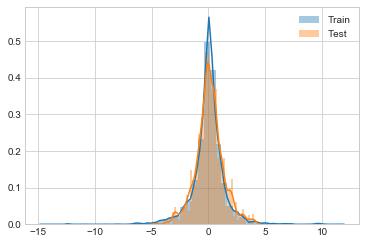

In [9]:
# Determine max post length
max_words_train = get_max_words(reddit_train_df.title.values)
max_words_test = get_max_words(reddit_test_df.title.values)
max_words = max(max_words_train, max_words_test)
print("Max number of words per post: {}".format(max_words))

# Label and title columns in datasets
LABEL_1HR, LABEL_2HR, LABEL_6HR, LABEL_12HR, LABEL_24HR = \
    '1hr_change', '2hr_change', '6hr_change', '12hr_change', '24hr_change'
TEXT_COL = 'title'

# Split into x_train and y_train
print('\nGetting x_train, y_train, x_test, and y_test...')
(x_train, y_train_1hr, y_train_2hr, y_train_6hr, y_train_12hr, y_train_24hr) = \
    reddit_train_df[TEXT_COL].values, reddit_train_df[LABEL_1HR], reddit_train_df[LABEL_2HR], \
    reddit_train_df[LABEL_6HR], reddit_train_df[LABEL_12HR], reddit_train_df[LABEL_24HR]

m_train = x_train.shape[0]
y_train_1hr = y_train_1hr.values.reshape((m_train, 1))
y_train_2hr = y_train_2hr.values.reshape((m_train, 1))
y_train_6hr = y_train_6hr.values.reshape((m_train, 1))
y_train_12hr = y_train_12hr.values.reshape((m_train, 1))
y_train_24hr = y_train_24hr.values.reshape((m_train, 1))
    
(x_test, y_test_1hr, y_test_2hr, y_test_6hr, y_test_12hr, y_test_24hr) = \
    reddit_test_df[TEXT_COL].values, reddit_test_df[LABEL_1HR], reddit_test_df[LABEL_2HR], \
    reddit_test_df[LABEL_6HR], reddit_test_df[LABEL_12HR], reddit_test_df[LABEL_24HR]

m_test = x_test.shape[0]
y_test_1hr = y_test_1hr.values.reshape((m_test, 1))
y_test_2hr = y_test_2hr.values.reshape((m_test, 1))
y_test_6hr = y_test_6hr.values.reshape((m_test, 1))
y_test_12hr = y_test_12hr.values.reshape((m_test, 1))
y_test_24hr = y_test_24hr.values.reshape((m_test, 1)) 

# Print info about train and test
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print("----------------------------")

# Plot distributions of labels
sns.set_style("whitegrid")
sns.distplot(reddit_train_df[LABEL_1HR].values, label='Train')
sns.distplot(reddit_test_df[LABEL_1HR].values, label='Test')
plt.legend()

# Model setup (part 1/3)

In [16]:
# Set hyperparameters
max_features = 200000 # Num words in our vocabulary 
maxlen = max_words  # cut texts after this number of words
batch_size = 32  # Mini-batch size
epochs = 5 

# Train tokenizer to create a vocabulary of words
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

# Vectorize each headline
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Update x_train and x_test to be 'sequences' of data
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = sequence.pad_sequences(test_sequences, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)  

Pad sequences (samples x time)
x_train shape: (102991, 78)
x_test shape: (9353, 78)


# Model setup (part 2/3)

In [6]:
# Build embedding layer using word2vec
EMBEDDING_FILE = "../../data/embeddings/GoogleNews-vectors-negative300.bin"
EMBEDDING_DIM = 300
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
        
embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False) 

# Model setup (part 3/3)

In [17]:
# Get the actual embeddings
sequence_input = Input(shape=(maxlen,), dtype='int32')
embeddings = embedding_layer(sequence_input)

# Construct the model (attempt 1 - didn't work)
#X = LSTM(128, return_sequences=True)(embeddings)
#X = Dropout(0.5)(X)
#X = LSTM(128, return_sequences=False)(X)
#X = Dropout(0.5)(X)
#X = Dense(1, activation='sigmoid')(X)

# Construct the model (attempt 1 - didn't work)
X = Bidirectional(LSTM(128, return_sequences=False))(embeddings)
X = Dense(5)(X)

# Select y labels
y_train = np.concatenate((y_train_1hr, y_train_2hr, y_train_6hr, y_train_12hr, y_train_24hr), axis=1)
y_test = np.concatenate((y_test_1hr, y_test_2hr, y_test_6hr, y_test_12hr, y_test_24hr), axis=1)

# Run BTC for 5 epochs

In [ ]:
# Define the BTC model
model = Model(inputs=sequence_input, outputs=X)

# Compile the BTC model
model.summary()
model.compile(loss='mean_squared_error', 
                    optimizer='adam', 
                    metrics=['accuracy'])

# Setup model checkpoint
checkpoint_5 = ModelCheckpoint("checkpoints/reddit-5epochs.hdf5")

# Run the BTC model
model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data=(x_test, y_test),
          callbacks=[checkpoint_5])

score, acc = model_btc.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run BTC model for 15 more epochs

In [18]:
# Setup model checkpoints\n",
checkpoint_10 = ModelCheckpoint("checkpoints/reddit-10epochs.hdf5")
checkpoint_15 = ModelCheckpoint("checkpoints/reddit-15epochs.hdf5")
checkpoint_20 = ModelCheckpoint("checkpoints/reddit-20epochs.hdf5")

# Run the BTC model 5 more epochs\n",
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint_10])

score, acc = model.evaluate(x_test,
                            y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the BTC model 5 more epochs\n",
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint_15])

score, acc = model.evaluate(x_test,
                            y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the BTC model 5 more epochs\n",
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint_20])

score, acc = model.evaluate(x_test,
                            y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


9353/9353 [==============================] - 8s 892us/step
Test score: 2.0105437362759964
Test accuracy: 0.000748422985011647
Train on 102991 samples, validate on 9353 samples
Epoch 1/10
102991/102991 [==============================] - 286s 3ms/step - loss: 1.3101 - acc: 0.0011 - val_loss: 2.0688 - val_acc: 6.4151e-04
Epoch 2/10
102991/102991 [==============================] - 289s 3ms/step - loss: 1.1804 - acc: 0.0011 - val_loss: 2.1797 - val_acc: 5.3459e-04
Epoch 3/10
102991/102991 [==============================] - 291s 3ms/step - loss: 1.0664 - acc: 0.0011 - val_loss: 2.1731 - val_acc: 5.3459e-04
Epoch 4/10
102991/102991 [==============================] - 290s 3ms/step - loss: 0.9696 - acc: 0.0011 - val_loss: 2.2821 - val_acc: 4.2767e-04
Epoch 5/10
102991/102991 [==============================] - 291s 3ms/step - loss: 0.8832 - acc: 0.0011 - val_loss: 2.4185 - val_acc: 6.4151e-04
Epoch 6/10
102991/102991 [==============================] - 292s 3ms/step - loss: 0.8066 - acc: 0.0011 -

# Load model checkpoints

In [19]:
###################################################################
# After 5 epochs
###################################################################
model_5 = Model(inputs=sequence_input, outputs=X)
model_5.load_weights("checkpoints/reddit-5epochs.hdf5")
model_5.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['accuracy'])
score_5, acc_5 = model_5.evaluate(x_test,
                                  y_test,
                                  batch_size=batch_size)
predictions_5 = model_5.predict(x_test)
print('Test score:', score_5)
print('Test accuracy:', acc_5)
                     
###################################################################
# After 10 epochs
###################################################################
model_10 = Model(inputs=sequence_input, outputs=X)
model_10.load_weights("checkpoints/reddit-10epochs.hdf5")
model_10.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_10, acc_10 = model_10.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_10 = model_10.predict(x_test)
print('Test score:', score_10)
print('Test accuracy:', acc_10)

###################################################################
# After 15 epochs
###################################################################
model_15 = Model(inputs=sequence_input, outputs=X)
model_15.load_weights("checkpoints/reddit-15epochs.hdf5")
model_15.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_15, acc_15 = model_15.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_15 = model_15.predict(x_test)
print('Test score:', score_15)
print('Test accuracy:', acc_15)

###################################################################
# After 20 epochs
###################################################################
model_20 = Model(inputs=sequence_input, outputs=X)
model_20.load_weights("checkpoints/reddit-5epochs.hdf5")
model_20.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_20, acc_20 = model_20.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_20 = model_20.predict(x_test)
print('Test score:', score_20)
print('Test accuracy:', acc_20)

9353/9353 [==============================] - 9s 924us/step
Test score: 11.454025297308688
Test accuracy: 0.32535015505596265
9353/9353 [==============================] - 9s 934us/step
Test score: 14.112859787844622
Test accuracy: 0.3053565700860581
9353/9353 [==============================] - 9s 921us/step
Test score: 16.574149997453823
Test accuracy: 0.28931893511059625
9353/9353 [==============================] - 9s 943us/step
Test score: 11.454025297308688
Test accuracy: 0.32535015505596265


# Evaluate the results
    - Look at the distribution of the predicted results to see if the model makes large predictions
    - Perform some error analysis

In [20]:
# Store predictions in list\n",
all_predictions = [('AFTER 5 EPOCHS TRAINING', predictions_5),
                   ('AFTER 10 EPOCHS TRAINING', predictions_10),
                   ('AFTER 15 EPOCHS TRAINING', predictions_15),
                   ('AFTER 20 EPOCHS TRAINING', predictions_20)]

# Loop through each set and print summary\n",
for description, prediction in all_predictions:
    pred_1hr, summary_1hr = prediction[:,0], pd.Series(np.squeeze(prediction[:,0])).describe()
    pred_2hr, summary_2hr = prediction[:,1], pd.Series(np.squeeze(prediction[:,1])).describe()
    pred_6hr, summary_6hr = prediction[:,2], pd.Series(np.squeeze(prediction[:,2])).describe()
    pred_12hr, summary_12hr = prediction[:,3], pd.Series(np.squeeze(prediction[:,3])).describe()
    pred_24hr, summary_24hr = prediction[:,4], pd.Series(np.squeeze(prediction[:,4])).describe()

    print('\n%s' % description)
    print('[+01 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_1hr['mean'], summary_1hr['min'], summary_1hr['25%'], summary_1hr['75%'], summary_1hr['max']))
    print('[+01 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_2hr['mean'], summary_2hr['min'], summary_2hr['25%'], summary_2hr['75%'], summary_2hr['max']))
    print('[+01 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_6hr['mean'], summary_6hr['min'], summary_6hr['25%'], summary_6hr['75%'], summary_6hr['max']))
    print('[+01 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_12hr['mean'], summary_12hr['min'], summary_12hr['25%'], summary_12hr['75%'], summary_12hr['max']))
    print('[+01 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_24hr['mean'], summary_24hr['min'], summary_24hr['25%'], summary_24hr['75%'], summary_24hr['max']))


AFTER 5 EPOCHS TRAINING
[+01 hr]	Mean: 0.0228	Min: -0.9305	25%: -0.0631	75%: 0.1112	Max: 0.9399
[+01 hr]	Mean: 0.0195	Min: -1.5050	25%: -0.1222	75%: 0.1651	Max: 1.8022
[+01 hr]	Mean: 0.1159	Min: -4.7486	25%: -0.2228	75%: 0.4615	Max: 4.9317
[+01 hr]	Mean: 0.2400	Min: -6.5284	25%: -0.2652	75%: 0.7602	Max: 7.4593
[+01 hr]	Mean: 0.4623	Min: -8.7002	25%: -0.3023	75%: 1.2281	Max: 9.2941

AFTER 10 EPOCHS TRAINING
[+01 hr]	Mean: 0.0260	Min: -1.4070	25%: -0.1506	75%: 0.1927	Max: 2.6116
[+01 hr]	Mean: 0.0589	Min: -2.6301	25%: -0.2617	75%: 0.3645	Max: 5.1058
[+01 hr]	Mean: 0.1841	Min: -8.5745	25%: -0.6412	75%: 0.9734	Max: 13.4106
[+01 hr]	Mean: 0.4062	Min: -12.1255	25%: -0.8545	75%: 1.6208	Max: 20.2075
[+01 hr]	Mean: 0.6845	Min: -15.7347	25%: -1.2130	75%: 2.5223	Max: 28.2422

AFTER 15 EPOCHS TRAINING
[+01 hr]	Mean: 0.0273	Min: -1.6031	25%: -0.1787	75%: 0.2236	Max: 1.9438
[+01 hr]	Mean: 0.0665	Min: -3.1627	25%: -0.3402	75%: 0.4541	Max: 4.4016
[+01 hr]	Mean: 0.1248	Min: -9.1286	25%: -0.9506	75%: 1

### First, print out text with corresponding percent changes greater than the cutoff

In [26]:
##### Set cutoff
cutoff = 3.0

test_text = list(reddit_test_df[TEXT_COL].values)
preds_list = list(np.squeeze(predictions))
labels_list = list(y_test)

count = 0
for i, label in enumerate(labels_list):
    if abs(label) >= cutoff:
        print('------------------')
        print('Text:\n {}'.format(test_text[i]))
        print('\tActual:  {}'.format(labels_list[i]))
        count += 1
        
print("----------------------")
print("Count of examples greater than cutoff: {}".format(count))

------------------
Text:
 BTC needs to rebound strongly or it may collapse the entire CC-space /Comments below
	Actual:  -3.8066297546900003
------------------
Text:
 Ask CoinTelegraph to replace BCH with LTC in twitter price feed!
	Actual:  -3.8066297546900003
------------------
Text:
 NavCoin: Where We Stand & Where We Are Going
	Actual:  -3.8066297546900003
------------------
Text:
 CPChain Listed on Bibox
	Actual:  -3.8066297546900003
------------------
Text:
 Daily market summary is very bullish, we're up 29%, led by ICX shooting up 71%. Big gains in NEO (56.15%) and XEM (47.18%).
	Actual:  -3.8066297546900003
------------------
Text:
 Rolling all 7's
	Actual:  -3.8066297546900003
------------------
Text:
 The crypto world is still so tiny little that it is so easy to manipulate with fake news and fuds. It happens all the time & even with big coins like Bitcoin, Ethereum and Ripple.
	Actual:  -3.8066297546900003
------------------
Text:
 SEC drags feet on approving Bitcoin ETFs - 

### Now print out the text corresponding to predictions greater than the cutoff

In [27]:
count = 0

for i, pred in enumerate(preds_list):
    if abs(pred) >= cutoff:
        print('------------------')
        print('Text:\n {}'.format(test_text[i]))
        print('\tPrediction: {}'.format(pred))
        print('\tActual:  {}'.format(labels_list[i]))
        count += 1

print("----------------------")
print("Count of examples greater than cutoff: {}".format(count))

------------------
Text:
 What does this whole 'Chickun' meme mean?
	Prediction: 3.5492334365844727
	Actual:  -0.48057669203000003
------------------
Text:
 US Gov gives cryptocurrency the green light - markets respond with an $83 billion one day boost
	Prediction: 4.453371524810791
	Actual:  4.01444815356
------------------
Text:
 I wonder how those feel that invested in Davor after Bitconnect. I‘d say buy the dip?
	Prediction: -3.861229419708252
	Actual:  4.01444815356
------------------
Text:
 Is CarVertical good buying opportunity or shitcoin?
	Prediction: 3.602163314819336
	Actual:  4.01444815356
------------------
Text:
 CNET: "My Life with Bitcoin" video. Hahahaha! I don't know why I love this so much. I really shouldn't, but it made me laugh out loud several times today. I needed that!
	Prediction: -3.4499425888061523
	Actual:  3.05077563792
------------------
Text:
 Terrible Store of Value - Repurposed credit cards and acrylic on used bank safety deposit box - 11 in x 21.5 in 